
## Introduction
In this demo we consider two datasets acquired in parallel. We hypothesize that both datasets are non-stationary: besides the known inputs the data are affected by internal latent dynamics. We also hypothesize that some of this latent dynamics is shared between the two datasets. We propose a model that allows us to find this latent dynamics (which we call state), and find model weights for both datasets. Ultimately our model allows us to represent the data as a sum of a dynamic and a static component, with each likely arising due to different underlying processes - thus giving us additional insight into original data. 

Here we skip the proof-of-concept simulations and directly work with experimentally acquired data, for this demo we use one example experiment out of many. The data is acquired from a subject doing many repetitions (trials) of a binary choice task, while the subject's brain activity and movements are recorded. 

#### Two datasets
The subject's task is to choose "0" or "1" based on the visual stimulus, whose intensity changes from -pi to +pi, with "-pi" being a strong evidence for choice "0", and "+pi" being a strong evidence for choice "1". The first _behavioral_ dataset consists of the choice _y_ on every trial and intensity (difficulty) _x_ on every trial. Because subjects are almost always found to be biased by previous choices, we will also use previous trial's choice and binarized intensity when modelling current trial's choice. The dimensions of _y_ and _x_ are therefore Nx1 and NxM where N is the number of trials and M is the number of all relevant behavioral inputs.

The second dataset consists of real-valued brain activity _z_ and an array that contains times of detected movements as binary event vectors. On every trial, activity _z_ and movement data are acquired over 2.5 s, in time bins of 0.1 s. The dimensions are therefore (T=25)xN for both the _z_ and movement data. 

#### Two models of observations
We model choice on trial _i_ using a standard sigmoid function of the dot-product of inputs _x_ and respective weights _w_ : $y_i = 1/(1+e^{-\mathbf{x}_i \mathbf{w}_i})$ note again that since the model is nonstationary, $w_i \neq w_j$ , $\forall i \neq j$

Our basic model for brain activity _z_ is convolutional: responses to an input $x_{z}$ are characterized by a convolutional kernel _k_ that is mostly causal (acting "forward" from an input event) but can have anti-causal effect too (in a period leading up to an event); thus generally $z(t)=x(t)*k+\eta$ where $\eta$ is Gaussian noise.
Note again that the nonstationary kernels $k_i$ vary from trial to trial, i.e.  $z_i(t)=x_{zi}(t)*k_i+\eta$ .
Finally, we find it reasonable to model _k_ as a sum of a stationary (trial-independent) component $k_s$ and a dynamic one $k_d$, i.e. $k_i=k_{s}+k_{di}$ because dynamic changes in _k_ occur "around" the average kernel.

Generally, we model a shared dynamics between _w_ and _k_ via a projection matrix A: $k_d$ is "modulated" by a dot product $Aw$ : $k_d = (Aw)k_{d0}$ ; but in this demo we are going to use only one dimension of _w_ and one dimension of _k_ for simplicity, so the "modulation" of $k_d$ is directly done by _w_ : $k_i=k_{s}+w_ik_{d0}$ . In other words, the dynamic kernel is represented as a sum of a static kernel $k_s$ and a dynamic "template" kernel $k_{d0}$ modulated by the varying _w_ .

#### How we fit the dynamic weights
We fit the latent dynamics by assuming a random walk prior on _w_ : for any trial _i_ $w_{i+1}-w_i \sim N(0,\sigma)$ , where $\sigma$ is the volatility hyperparameter. One can show that the inverse of prior covariance of _w_ is $C^{-1}=D^T\Sigma^{-1} D$ , where $D$ is a NxN difference matrix (ones on the main diagonal, minus ones on the diagonal below), and $\Sigma$ is an NxN diagonal matrix with $\sigma^2$ on the diagonal, i.e. covariance of random walk increments.
We can then find _w_ by maximizing the log-posterior $log( p(w|x,y) ) = L(y|x,w) + \frac{1}{2} log|C^{-1}| - \frac{1}{2} \mathbf{w}^TC^{-1}\mathbf{w} + const$ , where L(y|x,w) is log-likelihood given the sigmoid model of choices, and $\mathbf{w}$ is a concatenated vector of _w_ weights across all trials. If M>1, the dimensions of $C,D,\Sigma$ are changed as necessary to ensure the equation for the posterior is written with respect to _w_ in vectorized dimensions N*M x 1.

After the _w(t)_ is fitted this way, one can recover the "psychometric curves" - the sigmoids that correspond to the choice "strategies" at any point in the experiment. One can find that these sigmoids constantly change their slope and bias (see figure). 

Using the _w(t)_ - here, only one dimension that represents the "difficulty" weight - we look at the dynamic brain responses _z_.

#### How we fit the dynamic kernels
But first, we re-formulate the problem of finding the convolutional kernel _k_ as a regression problem. For that, we transform time-vectors of inputs $x_z(t)$ into a design matrix X, so that $z=x*k$ can be rewritten as a matrix equation $z=Xk$ with "features" of X corresponding to time-lags $\tau$ within the kernel _k_. We can then treat finding _k_ as a regularized least squares, so in the following we fit _k_ using scipy.linear_model.BayesianRidge .
With this approach we first ignore the variable _w_ and fit a fully static kernel (see figure).
Next we fit the model with the static/dynamic split of the kernel, in which the dynamic template kernel is modulated by _w_ : $k_i=k_{s}+w_ik_{d0}$ . We fit $k_{s}$ and $k_{d0}$ using regularized regression, and compare these two kernels to the static-only solution. 

Interestingly, the dynamic model splits the fully static kernel on two distinct temporal profiles: the kernel of _w_-independent responses has an early sharp peak and then decreases rapidly. The dynamic component of the kernel has a later peak that comes about 800 ms after the maximum of the static component. Static-only kernel could not distinguish between these two components, instead finding a compromise solution that envelopes them both (seen in green dash on the last figure). 


#### Conclusion
Both the choice dataset and brain activity dataset can be fitted with static weights to an adequate result. However, by allowing the weights to change smoothly with time, we could model the choice data more accurately, and we could find additional structure behind the neural response kernels. 

### I. Load and write data into variables

In [1]:
# Read a MATLAB file using scipy i/o
from scipy import io as sio

fname = 'data.mat'
data = sio.loadmat(fname)


# Write behavioral data structure 'beh' into a dictionary;
# load movement onset events 'pdi' and neural responses 'dF/F'
beh = data['beh']
beh_dict = {name: beh[name][0][0] for name in beh.dtype.names}
pdi = beh['pdi'][0][0][0]
print( f'behavioral variables: {beh_dict.keys()}' )
print('their dimensions:')
[print(value.shape) for value in beh_dict.values()]

dff = data['dff']
print( f'shape of dF/F neural data array (timebins, trials) - {dff.shape}' )

behavioral variables: dict_keys(['dif', 'ch', 'outc', 'tr', 'sess', 'pdi', 'to', 'rh', 'sh', 'ori', 'readme'])
their dimensions:
(2168, 1)
(2168, 1)
(2168, 1)
(2168, 1)
(2168, 1)
(1, 3)
(2424, 1)
(2168, 1)
(2168, 1)
(2168, 2)
(1,)
shape of dF/F neural data array (timebins, trials) - (25, 2168)


### II. Optimize the behavioral internal state

In [2]:
# Prepare inputs. Create prior covariance matrix

import numpy as np
from model import calcC_useSparse

sgma = 0.03

x_ext = np.concatenate( (beh_dict['dif'], beh_dict['rh'], beh_dict['sh'], np.ones(beh_dict['dif'].shape) ) , axis=1)
print(x_ext.shape)
y_dyn = beh_dict['ch'].ravel()

N,M = x_ext.shape

Cm1, logdetCm1 = calcC_useSparse(N,M,sgma)
Cm1 = np.asarray(Cm1)

(2168, 4)


#### Find the 4d dynamic state by optimizing log posterior ~ 40s

In [3]:
from model import calcpy, calclogpost, calcdLdw

w0 = np.zeros_like(x_ext.ravel())

sigmoid = lambda x,w: 1/(1 + np.exp(-x.dot(w))) # this is the psychometric function
py = lambda w: calcpy(w,x_ext,y_dyn) # likelihood of choices y_dyn given inputs x and weights w
mlogpost = lambda w: -calclogpost(w,Cm1,logdetCm1,py) # minus log-posterior
mdLdw = lambda w: -calcdLdw(w,x_ext,y_dyn,Cm1) # minus derivative of log-posterior

from scipy.optimize import minimize, Bounds

bds = Bounds(-10*np.ones_like(w0), 10*np.ones_like(w0))

out = minimize(mlogpost, w0, jac=mdLdw, bounds=bds, options={'disp': True} )

#### Plot the fitted w(t), all four dimensions; plot sigmoid curves at three different time points

(-2, 2)

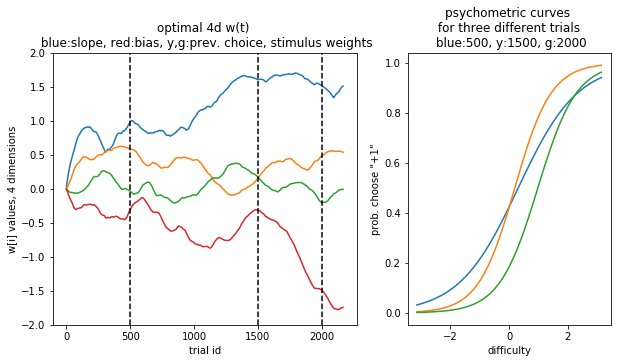

In [4]:
import matplotlib.pyplot as plt



# left plot: show the time course of the four psychometric weights

w_opt = np.reshape(out.x,(-1,4))
fig,ax=plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios':[3,2]})
ax[0].plot( w_opt )
ax[0].set_xlabel('trial id')
ax[0].set_ylabel(f'w[i] values, {M} dimensions')
ax[0].set_title(f'optimal {M}d w(t) \n blue:slope, red:bias, y,g:prev. choice, stimulus weights')



# right plot: show the psychometric curves at three periods in time

n_vals = 100
x_difficulty = np.linspace(-np.pi,np.pi,n_vals)[:,np.newaxis] # difficulty input of the psychometric function 
x_history = np.zeros((n_vals,1)) # history inputs - both zeroed for this analysis
x_bias = np.ones((n_vals,1)) # bias input
x_sigmoid = np.concatenate( (x_difficulty, x_history, x_history, x_bias) , axis = 1)


trial_ids = [500,1500,2000]
psych_1 = sigmoid(x_sigmoid,w_opt[ trial_ids[0],:])
psych_2 = sigmoid(x_sigmoid,w_opt[ trial_ids[1],:])
psych_3 = sigmoid(x_sigmoid,w_opt[ trial_ids[2],:])

plt.plot(x_difficulty, psych_1)
plt.plot(x_difficulty, psych_2)
plt.plot(x_difficulty, psych_3)
plt.xlabel('difficulty')
plt.ylabel('prob. choose "+1"')
plt.title(f'psychometric curves \n for three different trials \n blue:{trial_ids[0]}, y:{trial_ids[1]}, g:{trial_ids[2]}')

# mark the slices through weight vector that correspond to psychometric curves on the right
ax[0].plot(trial_ids[0]*np.ones((2,)), [-2, 2], '--k')
ax[0].plot(trial_ids[1]*np.ones((2,)), [-2, 2], '--k')
ax[0].plot(trial_ids[2]*np.ones((2,)), [-2, 2], '--k')
ax[0].set_ylim([-2,2])

### III. Fit z using a convolutional model

Text(0, 0.5, 'normalized response, dF/F')

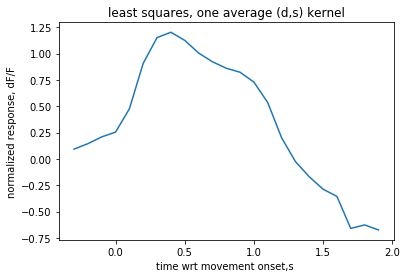

In [5]:
from model import prepInp, makeX
from sklearn import linear_model

z = dff.transpose()
z = z.ravel()
z = z / np.std(z)

K = 1 # take this many input channels for regression
T = 25 # trial length, time bins
inp_dim = 2 # input channel id; '2' corresponds to body movements
krnsz = np.asarray([3, 20]) # kernel length in time bins [pre-event,post-event] i.e. 
krnlen = krnsz[0]+krnsz[1]+1 

inp = pdi[inp_dim][:T,:]
inp = inp[:,:,np.newaxis]

inp_padded = prepInp(inp,N,T,krnsz,K) # zero-pad inputs to be used for X

X = makeX(inp_padded,T,krnlen,N,K) # create a design matrix from inputs: reframe convolution problem as regression

br = linear_model.BayesianRidge() # linear regression with automatic regularization

out_kavg = br.fit(X[:,:,0],z) 
kernel_avg = np.flipud( np.copy( out_kavg.coef_) ) # kernel time is flipped

dt = 0.1 #s
tau = np.arange(-krnsz[0],krnsz[1]) * dt
plt.plot( tau, kernel_avg[:-1] ) # ignore last timebin
plt.title('least squares, one average (d,s) kernel')
plt.xlabel('time wrt movement onset,s ')
plt.ylabel('normalized response, dF/F')

#### Fit the static and dynamic components of the kernel separately

Text(0.5, 1.0, 'blue:dynamic,yellow:static kernel components \n green:average if the dynamics is ignored')

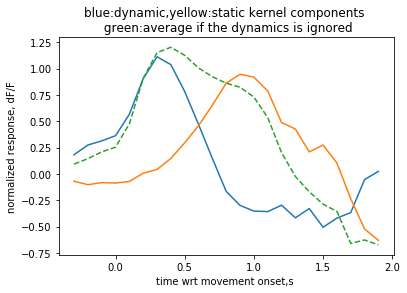

In [6]:
from model import calcXmodX

XmodX = calcXmodX(X[:,:,0], w_opt[:,[0]], T)

out_kboth = br.fit(XmodX, z)
kboth = np.flipud( np.copy( out_kboth.coef_) )
kernels = np.reshape( kboth,(krnlen,-1), order='F')

plt.figure()
plt.plot(tau, kernels[:-1,:])
plt.xlabel('time wrt movement onset,s ')
plt.ylabel('normalized response, dF/F')
plt.plot(tau, kernel_avg[:-1], '--')
plt.title('blue:dynamic,yellow:static kernel components \n green:average if the dynamics is ignored')